In [80]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

In [ ]:
x_min, x_max = 0.0, 50.0
y_top, y_bot = 0.0, -10.0
dx_nodes, dy_nodes = 5.0, 2.0

x_nodes = np.arange(x_min, x_max + 0.1, dx_nodes)
y_nodes = np.arange(y_top, y_bot - 0.1, -dy_nodes)
all_nodes = np.array([(xn, yn) for xn in x_nodes for yn in y_nodes])
num_nodes = len(all_nodes)

true_fault = {'start': (20.0, -2.0), 'end': (30.0, -6.0), 's_rate': -0.003}

x_obs = np.linspace(x_min, x_max, 101)

def calculate_velocities_semi_infinite(x_obs, s_rate, delta, d_start, x_start):
    if d_start == 0:
        arcterm = np.arctan2((x_obs - x_start), 1e-12)
        v1 = (s_rate / np.pi) * (np.cos(delta) * arcterm)
        v2 = -(s_rate / np.pi) * (np.sin(delta) * arcterm)
    else:
        zeta = (x_obs - x_start) / d_start
        v1 = (s_rate / np.pi) * (np.cos(delta) * np.arctan(zeta) +
                                (np.sin(delta) - zeta * np.cos(delta)) / (1.0 + zeta**2))
        v2 = -(s_rate / np.pi) * (np.sin(delta) * np.arctan(zeta) +
                                 (np.cos(delta) + zeta * np.sin(delta)) / (1.0 + zeta**2))
    return v1, v2

x1_true, z1_true = true_fault['start']
x2_true, z2_true = true_fault['end']
s_rate_true = true_fault['s_rate']
delta_true = np.arctan2(-(z2_true - z1_true), x2_true - x1_true)
v1_true_top, v2_true_top = calculate_velocities_semi_infinite(x_obs, s_rate_true, delta_true, -z1_true, x1_true)
v1_true_bot, v2_true_bot = calculate_velocities_semi_infinite(x_obs, -s_rate_true, delta_true, -z2_true, x2_true)
v2_true = v1_true_top + v1_true_bot
v2_true = v2_true_top + v2_true_bot

rng = np.random.default_rng(42)
sigma_mm = 0.2
sigma = sigma_mm / 1000.0
v2_noisy = v2_true + rng.normal(0.0, sigma, size=v2_true.shape)

ndim = 3

def log_prior(theta):
    start_idx, end_idx, s_rate = theta
    if not (0 <= start_idx < num_nodes and 0 <= end_idx < num_nodes):
        return -np.inf
    start_idx, end_idx = int(start_idx), int(end_idx)
    if not (-0.01 <= s_rate < 0):
        return -np.inf
    start_node = all_nodes[start_idx]
    end_node = all_nodes[end_idx]
    x1, z1 = start_node
    x2, z2 = end_node
    if not (x1 < x2 and z1 > z2):
        return -np.inf
    return 0.0

def log_likelihood(theta, x_obs, data, yerr):
    start_idx, end_idx, s_rate = theta
    start_node = all_nodes[int(start_idx)]
    end_node = all_nodes[int(end_idx)]
    x1, z1 = start_node
    x2, z2 = end_node
    delta = np.arctan2(-(z2 - z1), x2 - x1)
    v1_top, v2_top = calculate_velocities_semi_infinite(x_obs, s_rate, delta, -z1, x1)
    v1_bot, v2_bot = calculate_velocities_semi_infinite(x_obs, -s_rate, delta, -z2, x2)
    model_v2 = v2_top + v2_bot
    return -0.5 * np.sum(((data - model_v2) / yerr)**2)

def log_probability(theta, x_obs, data, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x_obs, data, yerr)

nwalkers = 500
ndim = 3

pos = np.zeros((nwalkers, ndim))
rng = np.random.default_rng()
for i in range(nwalkers):
    while True:
        start_idx, end_idx = rng.choice(num_nodes, size=2, replace=False)
        s_rate = rng.uniform(-0.01, 0)
        start_node = all_nodes[start_idx]
        end_node = all_nodes[end_idx]
        if (start_node[0] < end_node[0] and start_node[1] > end_node[1]):
            pos[i] = [start_idx, end_idx, s_rate]
            break

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x_obs, v2_noisy, sigma))
sampler.run_mcmc(pos, 1000, progress=True)
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)

100%|██████████| 1000/1000 [00:06<00:00, 156.40it/s]


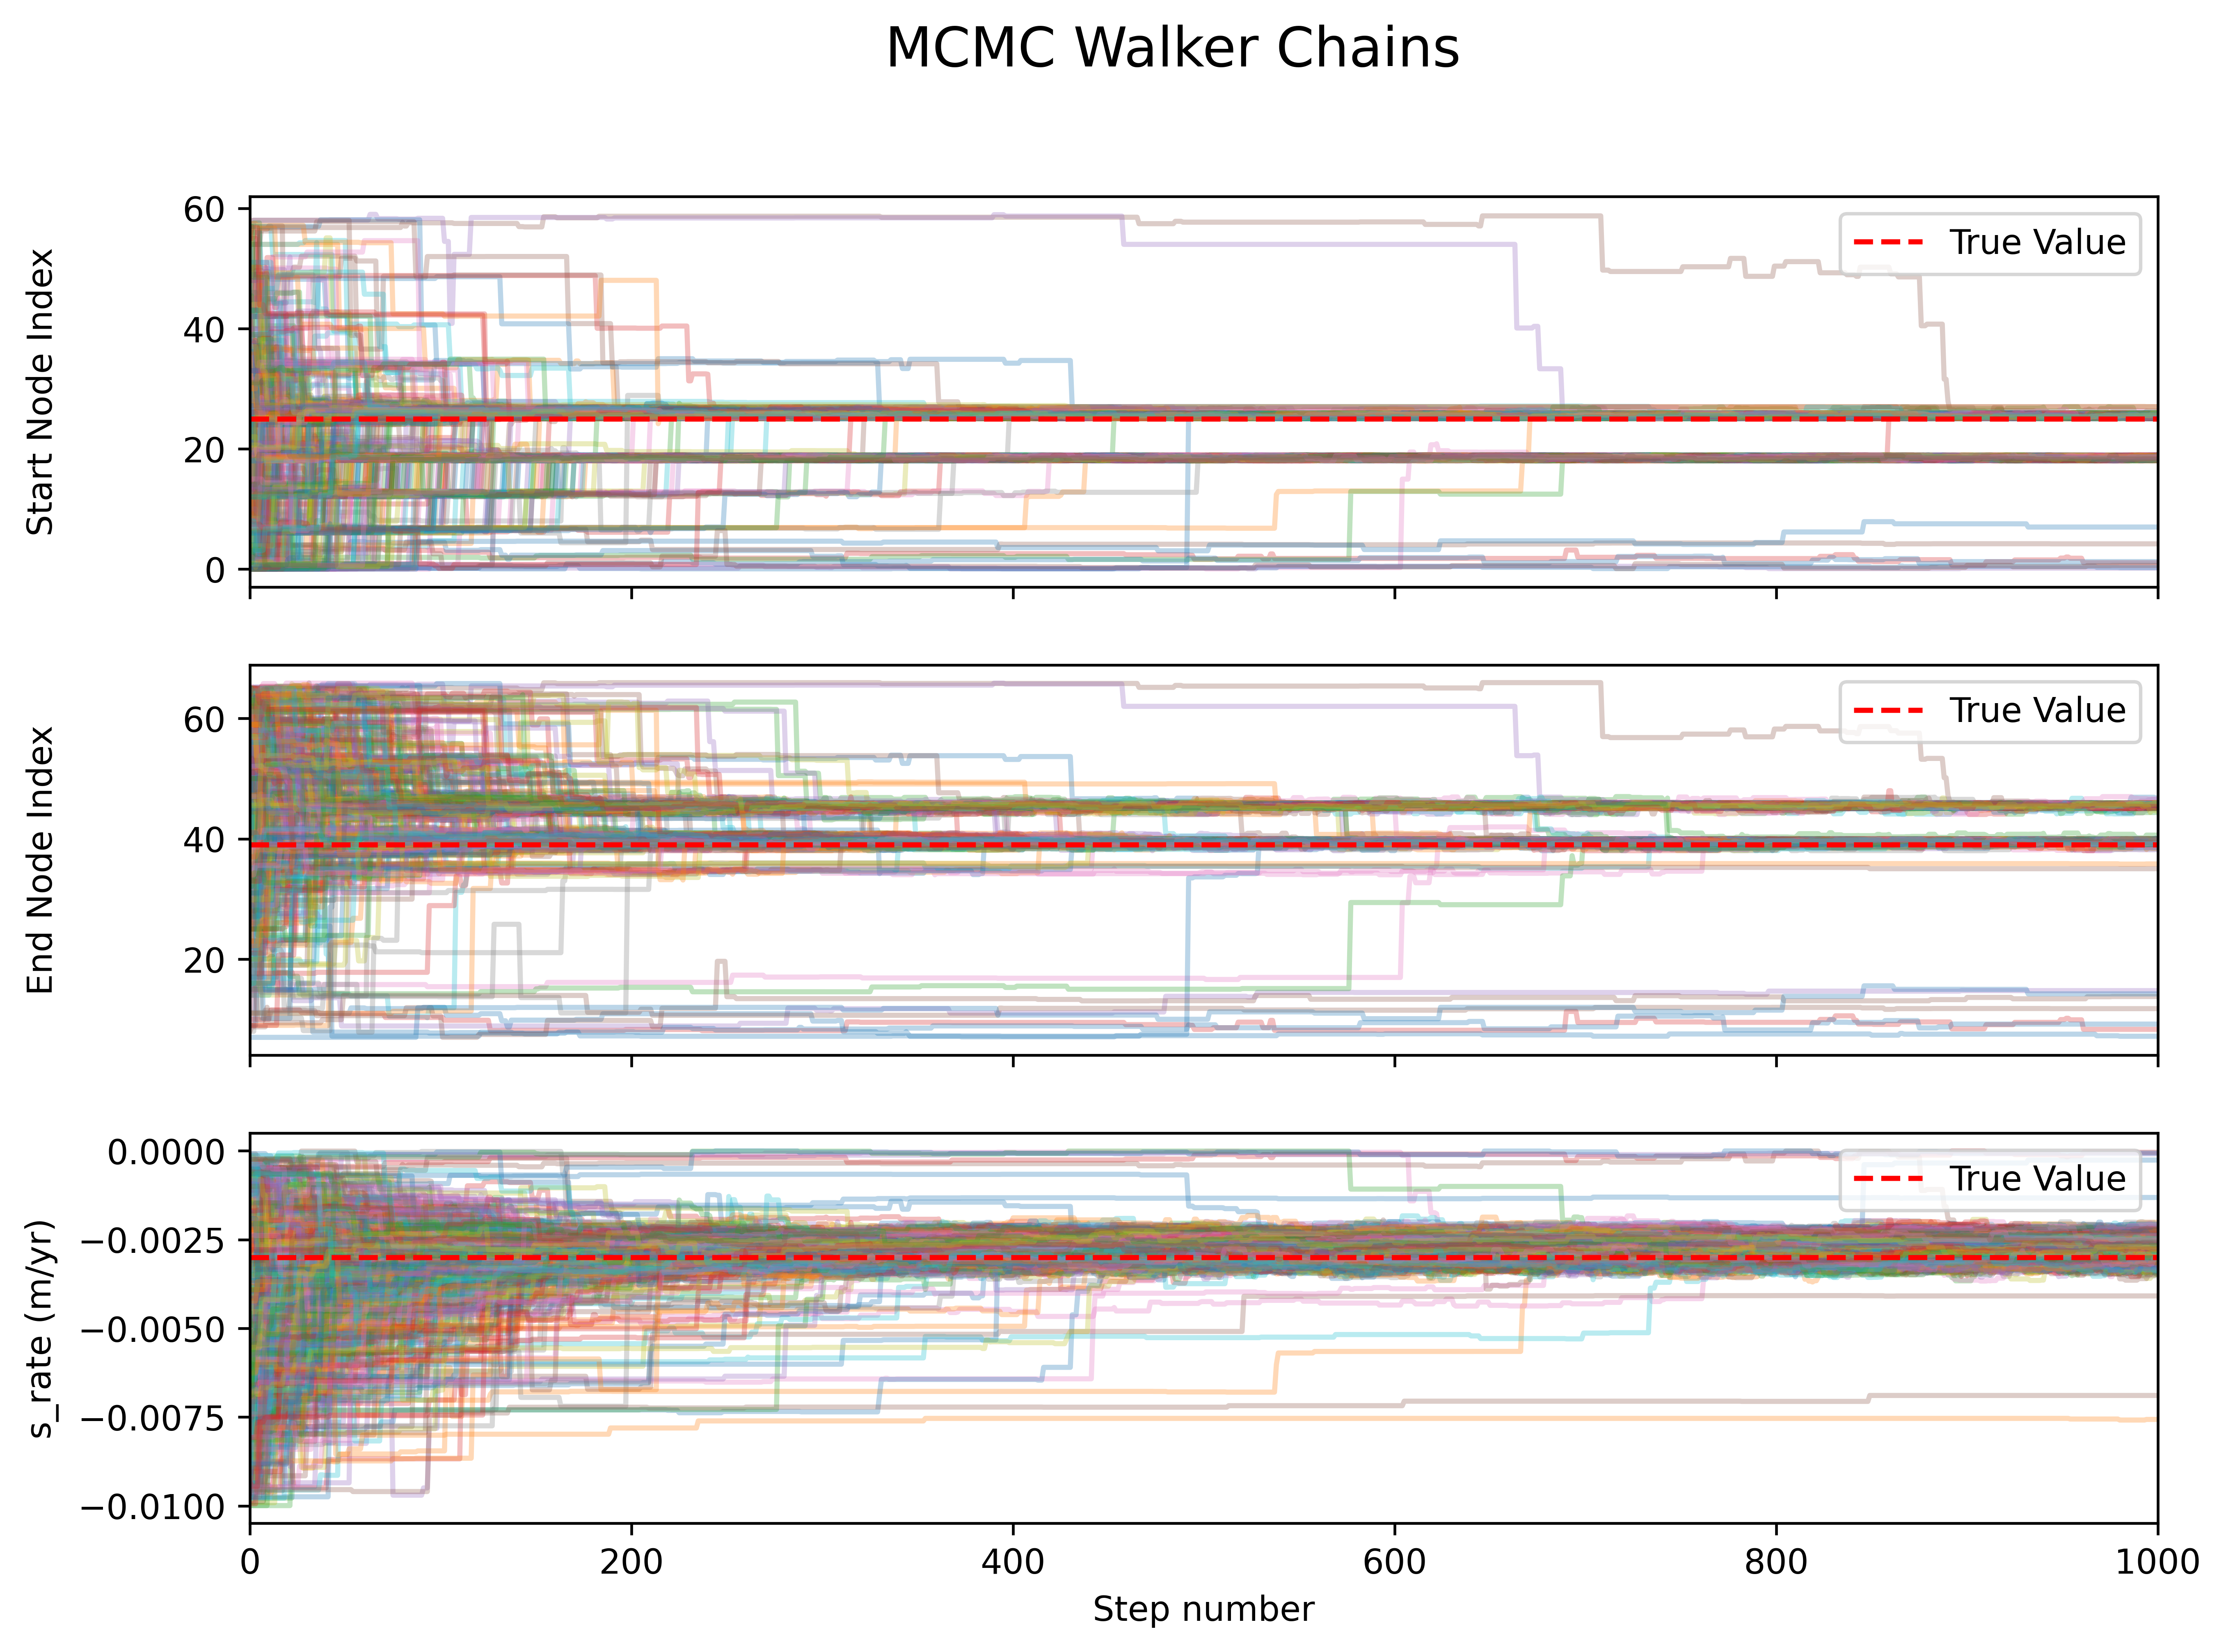

In [78]:
chain = sampler.get_chain()

labels = ["Start Node Index", "End Node Index", "s_rate (m/yr)"]
truths = [true_start_idx, true_end_idx, s_rate_true]

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
fig.suptitle("MCMC Walker Chains", fontsize=16)

for i in range(ndim):
    ax = axes[i]
    ax.plot(chain[:, :, i], alpha=0.3)
    ax.axhline(y=truths[i], color="r", linestyle="--", label="True Value")
    ax.set_xlim(0, len(chain))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.legend(loc="upper right")

axes[-1].set_xlabel("Step number")
plt.show()

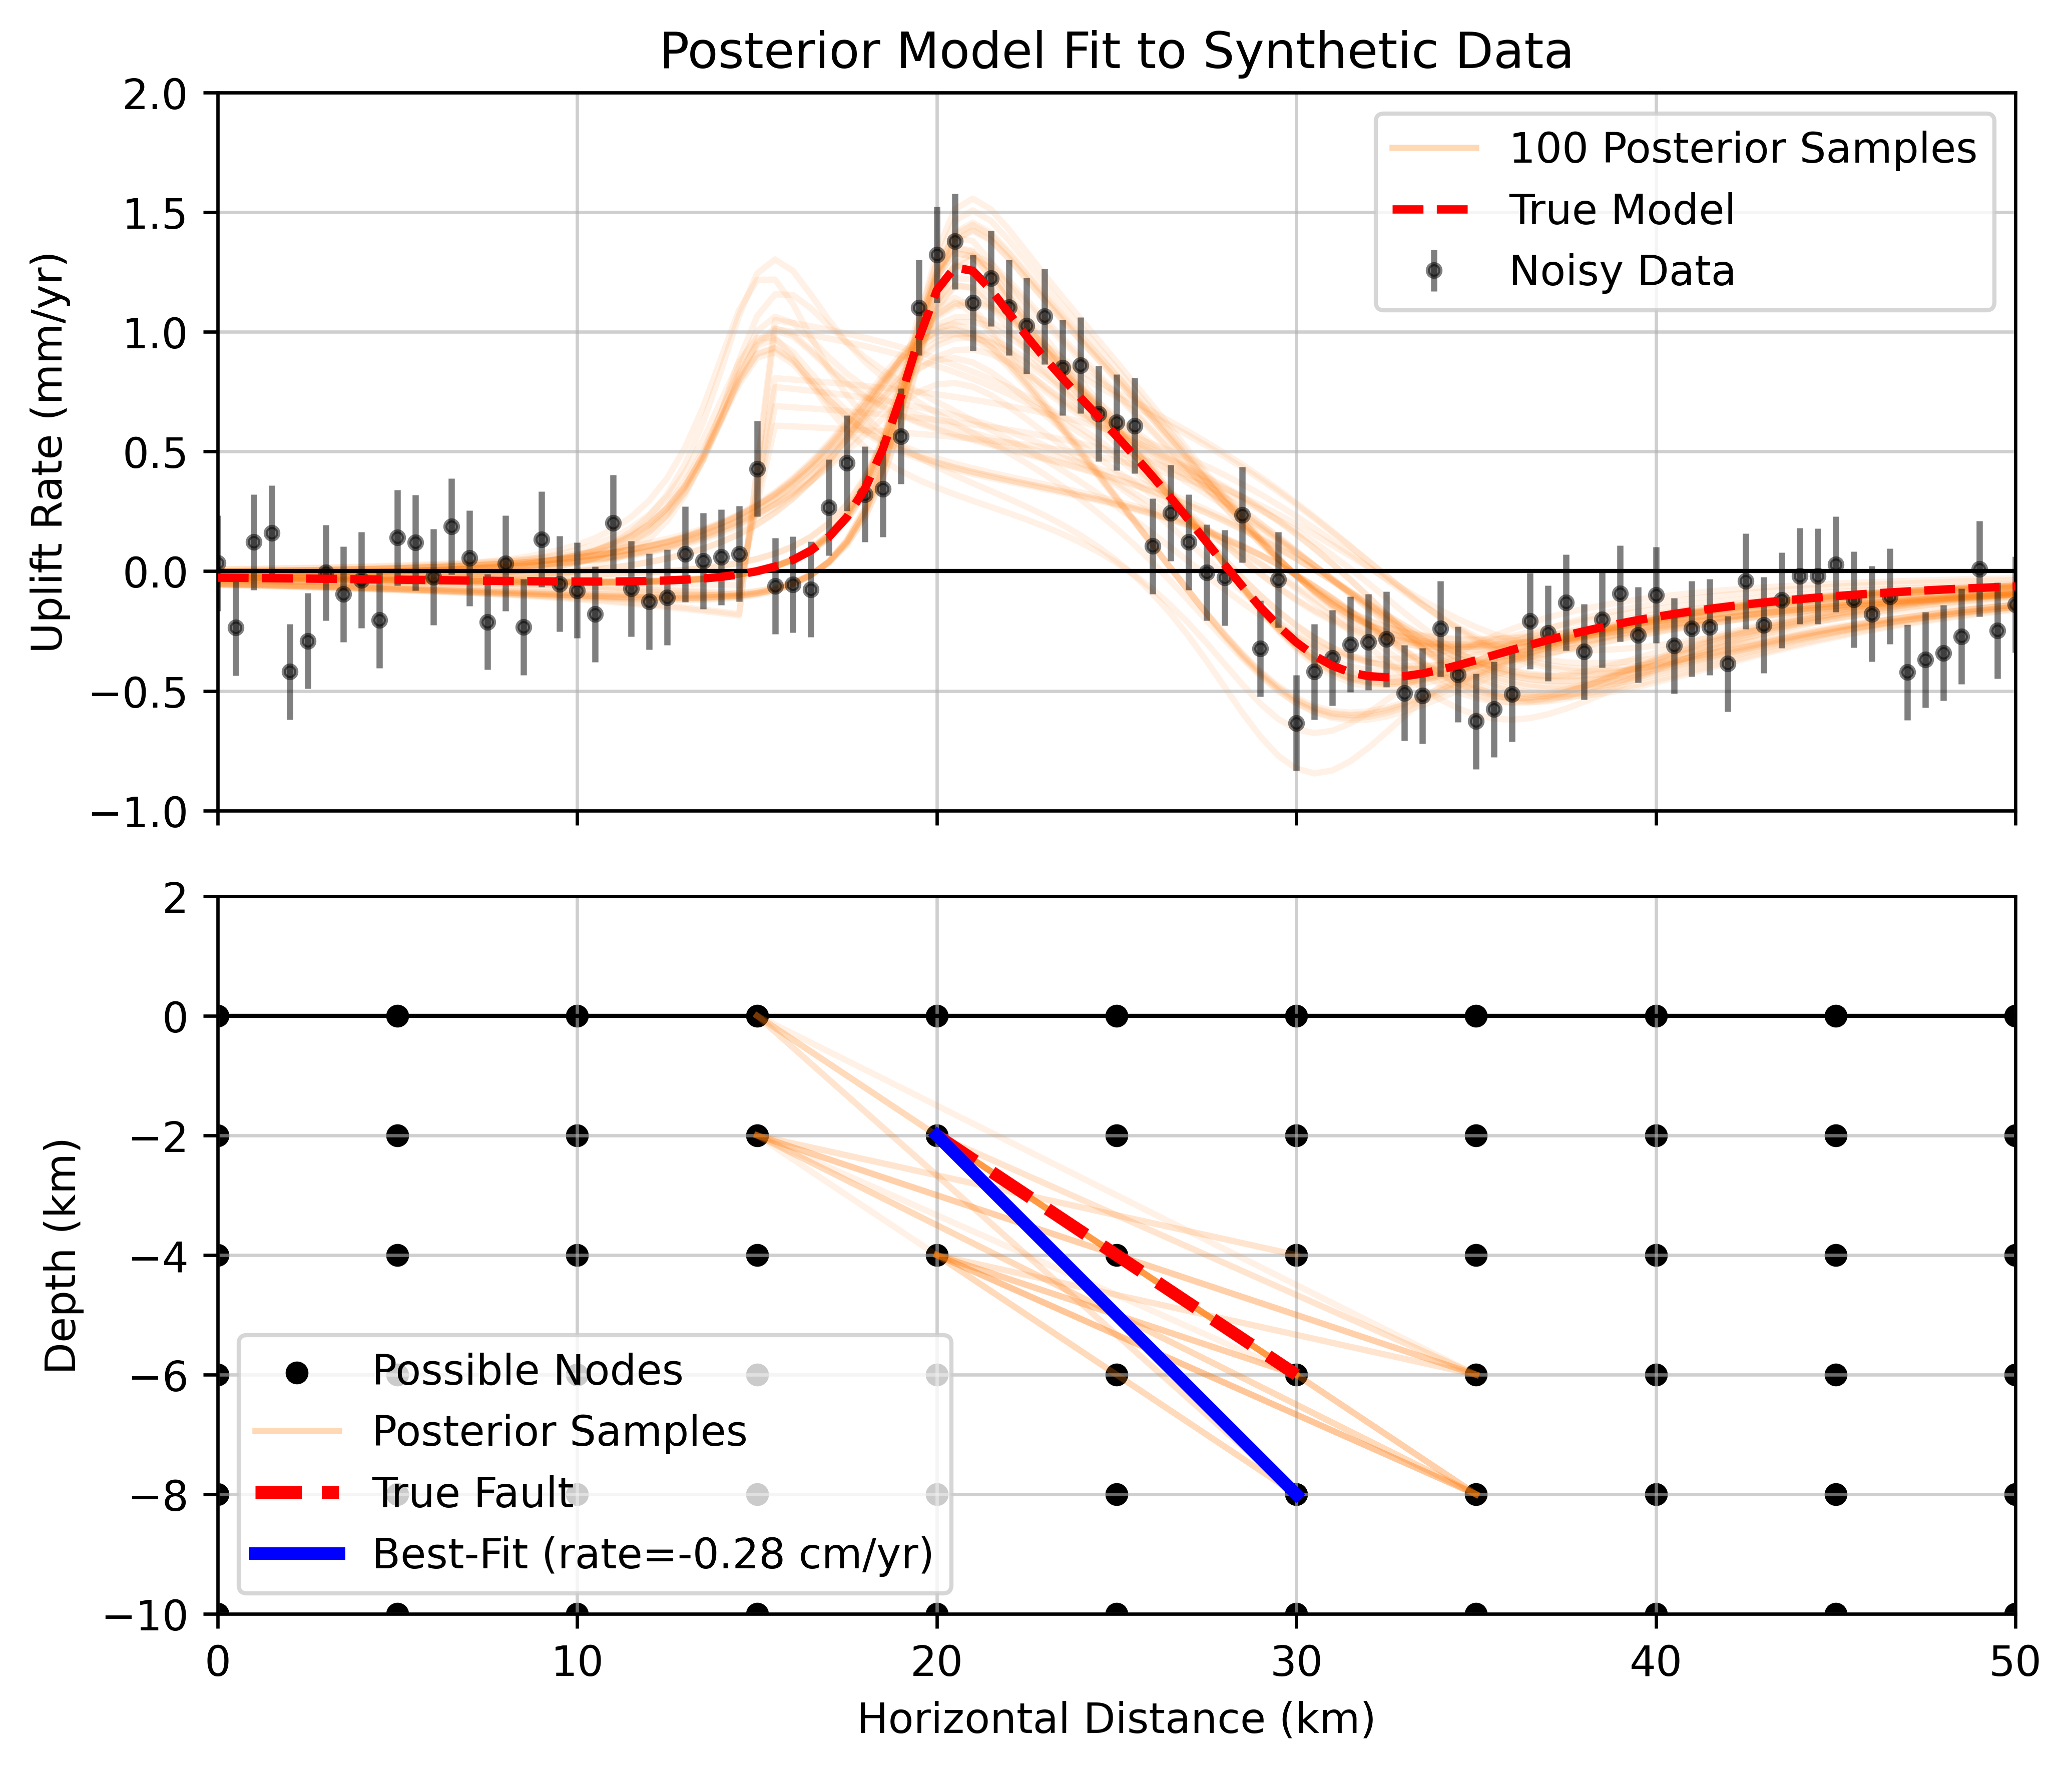

In [79]:
best_fit_params = np.percentile(flat_samples, 50, axis=0)
best_start_idx = int(np.round(best_fit_params[0]))
best_end_idx = int(np.round(best_fit_params[1]))
best_s_rate = best_fit_params[2]

best_start_node = all_nodes[best_start_idx]
best_end_node = all_nodes[best_end_idx]

fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(7, 6), sharex=True)
ax_top.set_xlim(x_min, x_max)

inds = np.random.randint(len(flat_samples), size=50)
for ind in inds:
    sample = flat_samples[ind]
    start_idx_s, end_idx_s, s_rate_s = sample
    start_node_s = all_nodes[int(np.round(start_idx_s))]
    end_node_s = all_nodes[int(np.round(end_idx_s))]
    x1_s, z1_s = start_node_s
    x2_s, z2_s = end_node_s
    delta_s = np.arctan2(-(z2_s - z1_s), x2_s - x1_s)
    v1_top_s, v2_top_s = calculate_velocities_semi_infinite(x_obs, s_rate_s, delta_s, -z1_s, x1_s)
    v1_bot_s, v2_bot_s = calculate_velocities_semi_infinite(x_obs, -s_rate_s, delta_s, -z2_s, x2_s)
    model_v2 = (v2_top_s + v2_bot_s)
    ax_top.plot(x_obs, model_v2 * 1000, "C1", alpha=0.1, zorder=1)

ax_top.plot([], [], "C1", alpha=0.3, label='100 Posterior Samples')
ax_top.errorbar(x_obs, v2_noisy * 1000, yerr=sigma_mm, fmt=".", color='black', label="Noisy Data", zorder=2, alpha=0.5)
ax_top.plot(x_obs, v2_true * 1000, color='red', lw=2, linestyle='--', label="True Model", zorder=3)
ax_top.axhline(0, lw=1.0, color='black')
ax_top.set_ylabel("Uplift Rate (mm/yr)")
ax_top.set_ylim([-1,2])
ax_top.set_title("Posterior Model Fit to Synthetic Data")
ax_top.legend(loc="best")
ax_top.grid(True, linestyle='-', alpha=0.6)

ax_bot.axhline(0, lw=1.0, color='black')
Xg, Yg = np.meshgrid(x_nodes, y_nodes)
ax_bot.scatter(Xg.flatten(), Yg.flatten(), s=20, c='k', zorder=1, label='Possible Nodes')
for ind in inds:
    sample = flat_samples[ind]
    start_idx_s, end_idx_s, _ = sample
    start_node_s = all_nodes[int(np.round(start_idx_s))]
    end_node_s = all_nodes[int(np.round(end_idx_s))]
    ax_bot.plot([start_node_s[0], end_node_s[0]], [start_node_s[1], end_node_s[1]], color="C1", alpha=0.1, zorder=2)
ax_bot.plot([], [], color="C1", alpha=0.3, label='Posterior Samples')
ax_bot.plot([true_fault['start'][0], true_fault['end'][0]], 
            [true_fault['start'][1], true_fault['end'][1]], 
            color='red', lw=3, linestyle='--', label="True Fault", zorder=3)
best_fit_label = f"Best-Fit (rate={best_s_rate*100:.2f} cm/yr)"
ax_bot.plot([best_start_node[0], best_end_node[0]], 
            [best_start_node[1], best_end_node[1]], 
            color='blue', lw=3, label=best_fit_label, zorder=4)

ax_bot.set_xlabel("Horizontal Distance (km)")
ax_bot.set_ylabel("Depth (km)")
ax_bot.set_ylim(y_bot, 2)
ax_bot.legend(loc="lower left")
ax_bot.grid(True, linestyle='-', alpha=0.6)

plt.tight_layout()
plt.show()